In [1]:


# Bibliotecas Básicas
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

# FrameWork utilizado --> Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Função para calculo de estatisticas de eficiencia
from sklearn.metrics import classification_report

# Pegando o Dataset pelo Keras
from keras.datasets import mnist

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Analise exploratoria dos dados

In [3]:
print('X_train: ' , train_X.shape)
print('Y_train: ', (train_y.shape))
print('X_test:  ', (test_X.shape))
print('Y_test:  ', test_y.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


Nessa database Tem-se um total de 70000 imagens de números, os quais serao separados 60000 para treinar o modelo e 10000 para testar o modelo treinado.

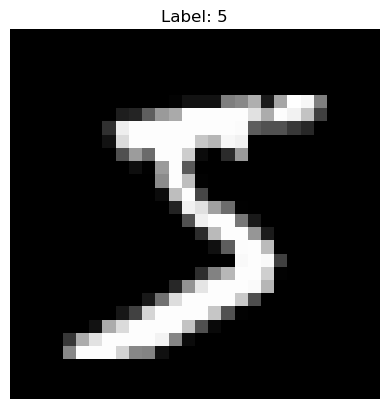

In [4]:

index = 0  # Escolha o índice da imagem que deseja visualizar
image = train_X[index]
label = train_y[index]

# Plotar a imagem
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

Cada Imagem é no formato 28x28 e cada celula tem uma 'tonalidade' de cinza, indicando como o pixel deve ser pintado para formar o número

# DataLoader
O data Loader será utilizado para poder pegar os dados aleatoriamente e controlar o "Batch Size"

In [5]:
class MNIST(Dataset):

    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]


In [6]:
train_dl = DataLoader(MNIST(train_X, train_y), batch_size=256, shuffle = True)
test_dl = DataLoader(MNIST(test_X, test_y), batch_size= 64)

# MLP

## Criando o Modelo de MLP

In [12]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model,self).__init__()


        self.A1 = nn.Flatten()
        self.L1 = nn.Linear(28*28,20)
        self.D1 = nn.Dropout(0.0)
        self.A2 = nn.Tanh()
        self.L2 = nn.Linear(20,40)
        self.L3 = nn.Linear(40,80)
        self.L4 = nn.Linear(80,10)
        


    def forward(self, x):

        x = self.A1(x)
        x = self.L1(x)
        x = self.D1(x)
        x = self.A2(x)

        x = self.L2(x)
        x = self.A2(x)
        x = self.L3(x)
        x = self.A2(x)
        x = self.L4(x)


        return x



## Treinando o modelo


In [36]:
def training( N_Epochs, model, loss_fn, opt  ):

    loss_list = []

    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:

            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())



            opt.zero_grad()
            loss.backward()
            opt.step()


        loss_list.append(loss.item())


    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")



100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


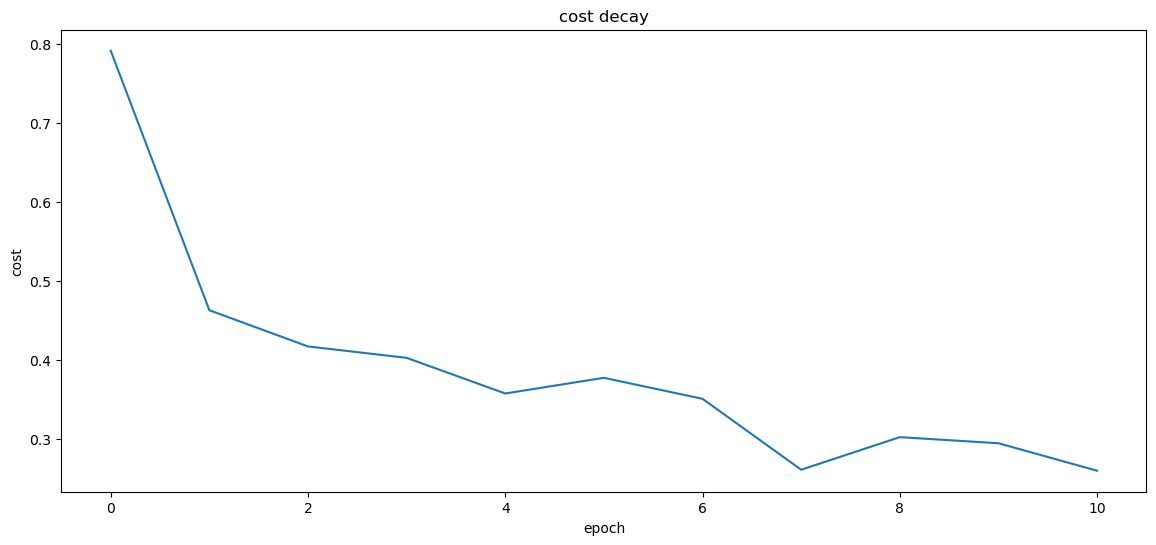

In [41]:
epoch = 10
model =  MLP_Model()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam( model.parameters(), lr=0.0003 )
training(epoch,model, loss, opt)

## Avaliando a efetividade do Modelo

In [40]:
with torch.no_grad():

    model.eval()

    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)

    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.97      0.97      1135
           2       0.93      0.93      0.93      1032
           3       0.90      0.92      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.90      0.91       892
           6       0.94      0.95      0.95       958
           7       0.92      0.94      0.93      1028
           8       0.93      0.89      0.91       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Testes para otimizar o modelo



Serão realizadas diversas variações no modelo para avaliar o impacto de cada hiperparâmetro na sua precisão.

As variações serão as seguintes:

    Número de camadas ocultas: 1 | 2 | 3
    Número de neurônios por camada: 20 | 40 | 80
    Função de custo: MSE | Cross Entropy
    Função de ativação: ReLU | Sigmoid | Tanh
    Dropout: 0 | 0.2 | 0.5
    Learning rate: 3 × 10⁻⁴ | 3 × 10⁻⁵ | 3 × 10⁻⁶
    Número de épocas: 3 | 7 | 10

Essa abordagem permitirá analisar como cada configuração influencia o desempenho do modelo.

In [65]:
df = pd.read_excel('data/MLP_data_complete_1977246.xlsx')
df.head()

,Iteration,Camadas,FnAtivação,FnCusto,LnRate,Epocas,DropOut,Precision,Recall,F1-Score,...,Unnamed: 14,Unnamed: 15,Accuracy.1,Iteration.1,Camadas.1,FnAtivação.1,FnCusto.1,LnRate.1,Epocas.1,DropOut.1
0,1/486,[20],ReLU,MSELoss,0.0003,3,0.0,0.8693,0.8626,0.8613,...,NaN,NaN,0.9561,366/486,"[20, 40, 80]",Tanh,CrossEntropyLoss,0.0003,10.0,0.0
1,2/486,[20],ReLU,CrossEntropyLoss,0.0003,3,0.0,0.9095,0.9094,0.9090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/486,[20],ReLU,MSELoss,0.0003,7,0.0,0.8960,0.8945,0.8944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/486,[20],ReLU,CrossEntropyLoss,0.0003,7,0.0,0.9247,0.9248,0.9246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5/486,[20],ReLU,MSELoss,0.0003,10,0.0,0.9189,0.9169,0.9171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Epocas', ylabel='Precision'>

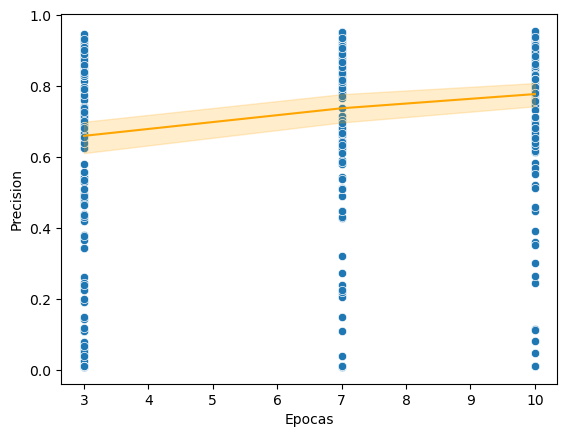

In [24]:
sns.scatterplot(data=df, x="Epocas", y="Precision")
sns.lineplot(data=df, x="Epocas", y="Precision", color='orange')  # Linha para mostrar tendência


<Axes: xlabel='LnRate', ylabel='Precision'>

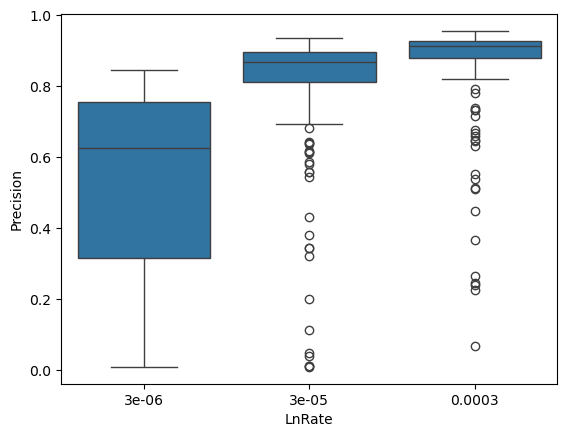

In [47]:
sns.boxplot(data=df, x="LnRate", y="Precision")




<Axes: xlabel='LnRate', ylabel='Epocas'>

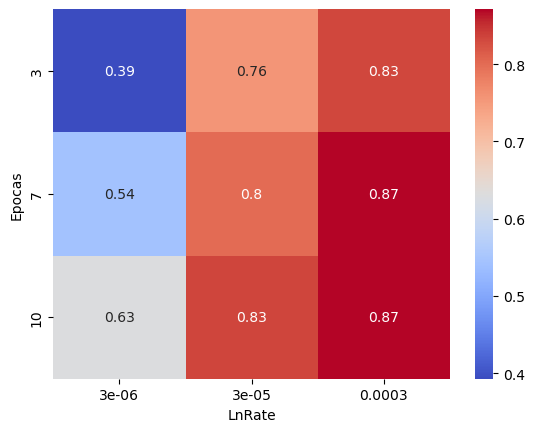

In [27]:
pivot_table = df.pivot_table(values="Precision", index="Epocas", columns="LnRate")
sns.heatmap(pivot_table, annot=True, cmap="coolwarm")


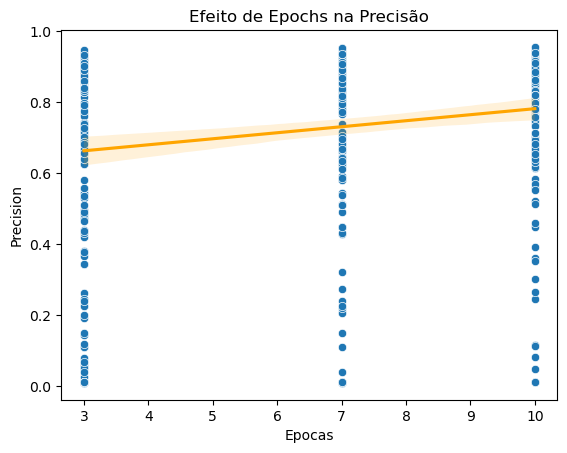

A precisão varia 0.02 por época. R²: 0.04


In [28]:

from scipy.stats import linregress

sns.scatterplot(data=df, x="Epocas", y="Precision")
sns.regplot(data=df, x="Epocas", y="Precision", scatter=False, color="orange")
plt.title("Efeito de Epochs na Precisão")
plt.show()
slope, intercept, r_value, p_value, std_err = linregress(df['Epocas'], df['Precision'])
print(f"A precisão varia {slope:.2f} por época. R²: {r_value**2:.2f}")


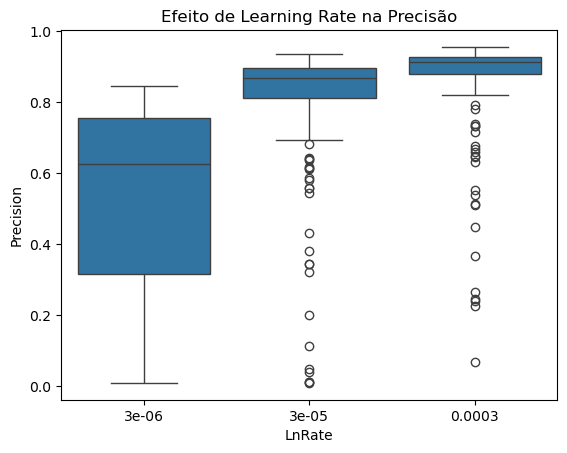

LnRate
0.000003    0.521683
0.000030    0.797110
0.000300    0.858030
Name: Precision, dtype: float64


In [29]:
sns.boxplot(data=df, x="LnRate", y="Precision")
plt.title("Efeito de Learning Rate na Precisão")
plt.show()
print(df.groupby("LnRate")["Precision"].mean())


(-0.5, 1983.5, 1483.5, -0.5)

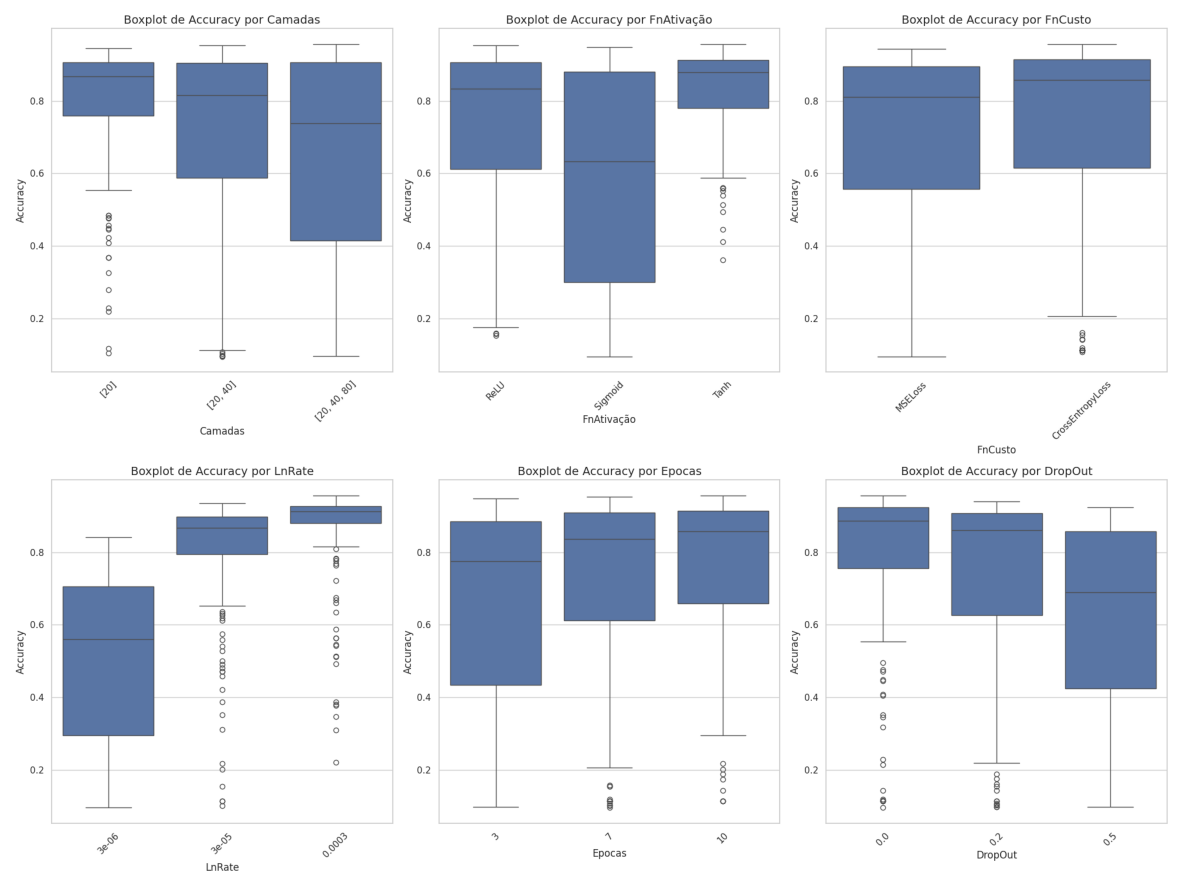

In [52]:
from PIL import Image
import matplotlib.pyplot as plt

# Carregar a imagem
imagem = Image.open("imgs/mlp1.png")

# Exibir a imagem
plt.figure(figsize=(15, 15))
plt.imshow(imagem)
plt.axis("off") 



(-0.5, 999.5, 599.5, -0.5)

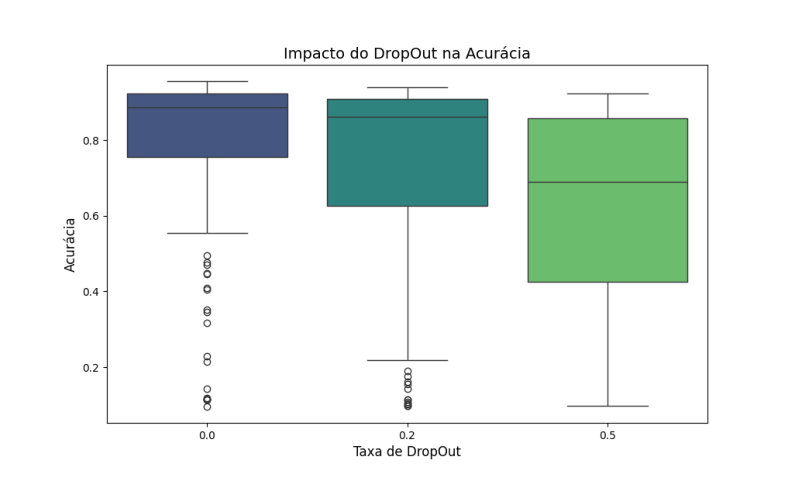

In [62]:
# Carregar a imagem
imagem = Image.open("imgs/mlp2.png")

# Exibir a imagem
plt.figure(figsize=(10, 10))
plt.imshow(imagem)
plt.axis("off") 


(-0.5, 999.5, 599.5, -0.5)

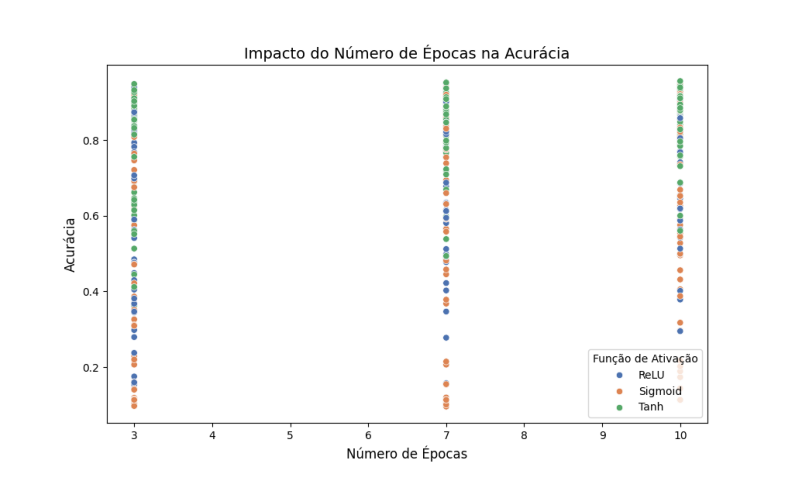

In [61]:
# Carregar a imagem
imagem = Image.open("imgs/mlp3.png")

# Exibir a imagem
plt.figure(figsize=(10, 10))
plt.imshow(imagem)
plt.axis("off") 


(-0.5, 1399.5, 699.5, -0.5)

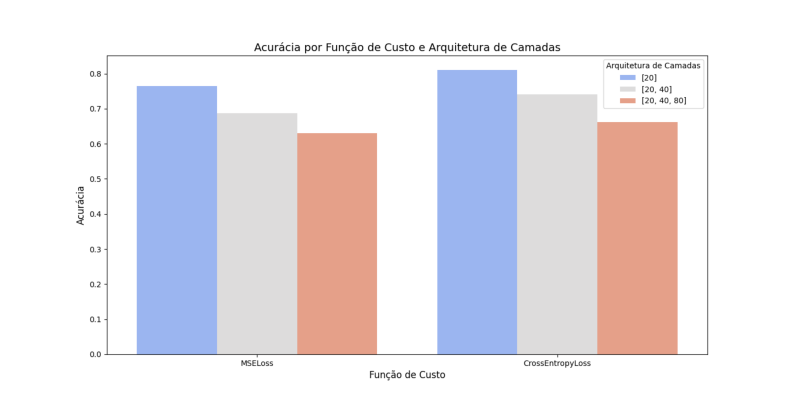

In [60]:
# Carregar a imagem
imagem = Image.open("imgs/mlp4.png")

# Exibir a imagem
plt.figure(figsize=(10, 10))
plt.imshow(imagem)
plt.axis("off") 


(-0.5, 799.5, 599.5, -0.5)

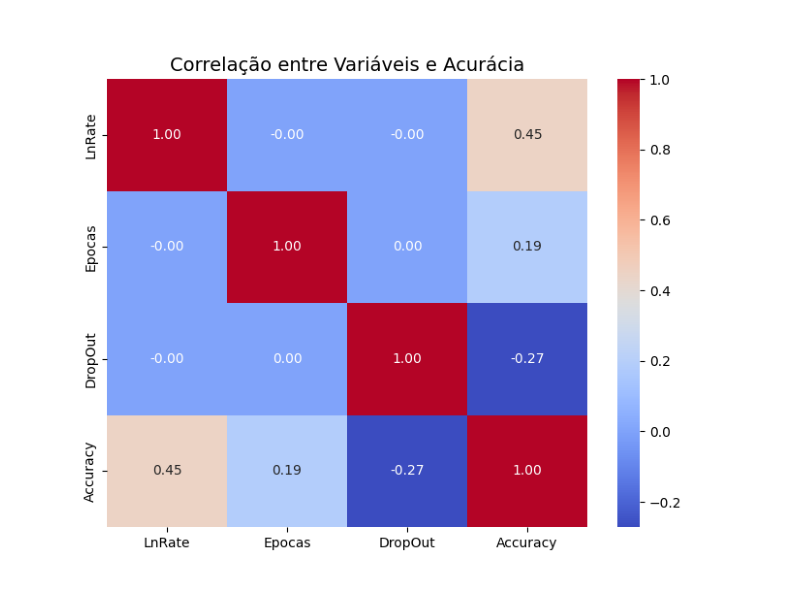

In [59]:
# Carregar a imagem
imagem = Image.open("imgs/mlp5.png")

# Exibir a imagem
plt.figure(figsize=(10, 10))
plt.imshow(imagem)
plt.axis("off") 


(-0.5, 999.5, 599.5, -0.5)

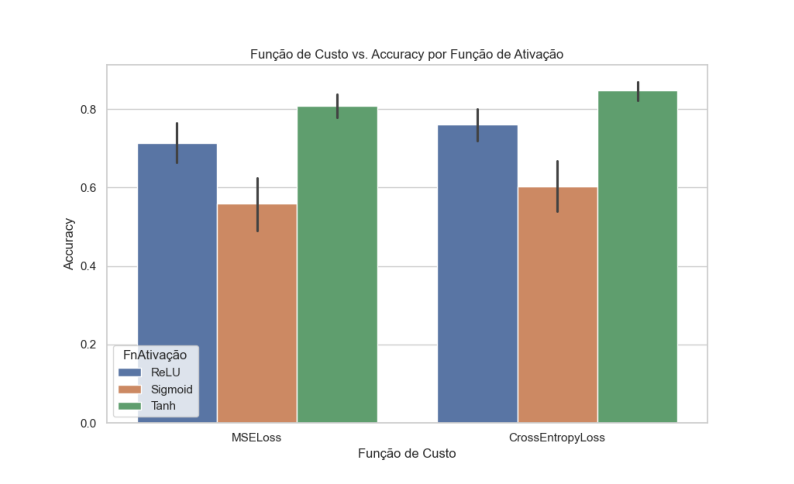

In [58]:
# Carregar a imagem
imagem = Image.open("imgs/mlp6.png")

# Exibir a imagem
plt.figure(figsize=(10, 10))
plt.imshow(imagem)
plt.axis("off") 


# CNN

## Alteração no formato dos dados para utilizar a CNN

In [30]:

train_X = train_X[:, None, :, :]  # Adiciona o canal (batch_size, 1, 28, 28)
test_X = test_X[:, None, :, :]

train_dl = DataLoader(MNIST(train_X, train_y), batch_size=256, shuffle = True)
test_dl = DataLoader(MNIST(test_X, test_y), batch_size= 64)

## Criando o Modelo CNN

In [32]:


# Criar uma classe que herda o modulo nn.Module

class CNN_Model(nn.Module):

    def __init__(self):
        super().__init__()

        # transformar a entrada em um único tensor unidimensional

        self.Fl = nn.Flatten()

        # a primeira camada de convolução
        # o parâmetro in_channels é para identificar as dimensões que a representação da sua imagem possuí, ex RGB = 3, gray_scale = 1, ou os mapas de características dado por camadas anteriores
        # e o out_channels é para a saída gerada pela unidade computacional, maiores valores gerarão mais mapas de características
        # o kernel e o stride podem assumir valores diferentes, mas por fins de simplificação iremos apenas passar inteiros

        self.C1 = nn.Conv2d(in_channels = 1, out_channels = 15, kernel_size = 2, stride = 1 )

        # após a operação de convolução, virá a operação de pooling
        # existem diferentes formas pela biblioteca para fazer a operação de pooling, mas utilizaremos o Max

        self.P1 = nn.MaxPool2d(kernel_size = 2)

        #segunda camada de convolução + pooling

        self.C2 = nn.Conv2d(in_channels = 15, out_channels = 10, kernel_size = 2, stride = 1)
        self.P2 = nn.MaxPool2d(kernel_size = 2)


        # Após n operações de convolução e pooling a imagem será achatada pela operação Flatten
        # e será usado em uma rede MLP
        # o pytorch não oferece maneiras dinâmicas de fazer alteração nos parâmetros da rede após a criação
        # então o valor das entradas e saídas após cada camada devem ser calculadas: output_size=((input_size−kernel_size+2×padding)/stride) + 1
        # para a primeira camada após a convolução temos output_size = 27
        # para a primeira camada após o pooling temos output_size =  13
        # para a segunda camada após a convolução temos output_size = 12
        # para a segunda camada após o pooling temos output_size = 6
        # então para a rede MLP teremos uma quantidade de entradas 16x16

        #primeira camada terá 100 unidades computacionais
        self.L1 = nn.Linear(10*6*6, 100)

        #segunda camada para 50 unidades computacionais
        self.L2 = nn.Linear(100, 50)

        #terceira camada para 10
        self.L3 = nn.Linear(50, 10)


    def forward(self, x):


        x = torch.sigmoid(self.C1(x))   # Primeira convolução + ReLU
        x = self.P1(x)                  # Primeiro pooling
        x = torch.sigmoid(self.C2(x))   # Segunda convolução + ReLU
        x = self.P2(x)                  # Segundo pooling
        x = self.Fl(x)                  # Flatten
        x = torch.sigmoid(self.L1(x))   # Primeira camada MLP
        x = torch.sigmoid(self.L2(x))   # Segunda camada MLP
        x = self.L3(x)                  # Saída final

        return x


## Treinando o Modelo CNN



In [34]:
epoch = 10
model =  CNN_Model()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam( model.parameters(), lr=0.01 )
training(epoch,model, loss, opt)

100%|██████████| 11/11 [01:25<00:00,  7.79s/it]


## Avaliando a CNN

In [35]:
with torch.no_grad():

    model.eval()

    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)

    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.99      0.94      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.93      0.97      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Testes Para optimizar o modelo


Para a CNN, serão exploradas diferentes variações nos hiperparâmetros com o objetivo de analisar o impacto de cada configuração no desempenho do modelo. As variações consideradas são:

    Tamanho do kernel: 2
    Stride do kernel: 1
    Função de ativação: ReLU | Sigmoid
    Função de custo: Cross Entropy | MSE
    Número de camadas de convolução: 1 | 2
    Tamanho do kernel de max pooling: 2
    Número de mapas de características: 5 | 10 | 15
    Número de épocas: 5 | 10 | 30
    Learning Rate: 10^(-5) | 10^(-2) | 5*10^(-1)

Essa análise ajudará a identificar como cada hiperparâmetro influencia o comportamento e a precisão da CNN.


In [31]:
df_CNN = pd.read_excel('data/CNN_data_complete.xlsx')
df_CNN

,Kernel Sizes,Strides,Pool Sizes,Num Maps Características,Num Layers,Learning Rate,Num Epochs,Func,Test Accuracy
0,"[2, 2]","[1, 1]","[2, 2]","[15, 10]",2,1.000000e-02,10,Sigmoid,98.16
1,"[2, 2]","[1, 1]","[2, 2]","[10, 15]",2,1.000000e-02,30,Sigmoid,98.15
2,"[2, 2]","[1, 1]","[2, 2]","[10, 15]",2,1.000000e-02,30,ReLU,98.08
3,"[2, 2]","[1, 1]","[2, 2]","[10, 15]",2,1.000000e-02,10,ReLU,98.07
4,"[2, 2]","[1, 1]","[2, 2]","[5, 10]",2,1.000000e-02,5,ReLU,98.04
...,...,...,...,...,...,...,...,...,...
132,"[2, 2]","[1, 1]","[2, 2]","[10, 5]",2,5.000000e-01,10,ReLU,8.92
133,"[2, 2]","[1, 1]","[2, 2]","[5, 5]",2,5.000000e-01,10,ReLU,8.92
134,"[2, 2]","[1, 1]","[2, 2]","[10, 15]",2,5.000000e-01,10,ReLU,8.92
135,[2],[1],[2],[5],1,5.000000e-01,10,ReLU,8.92


<Axes: xlabel='Learning Rate', ylabel='Test Accuracy'>

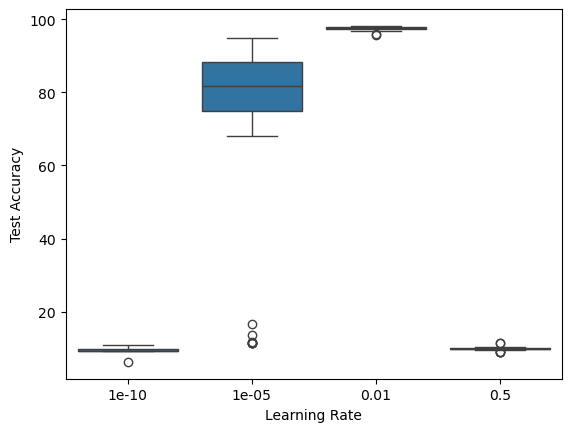

In [48]:
sns.boxplot(data=df_CNN, x="Learning Rate", y="Test Accuracy")




Correlação com a acurácia (Pearson):
Learning Rate_log: -0.080


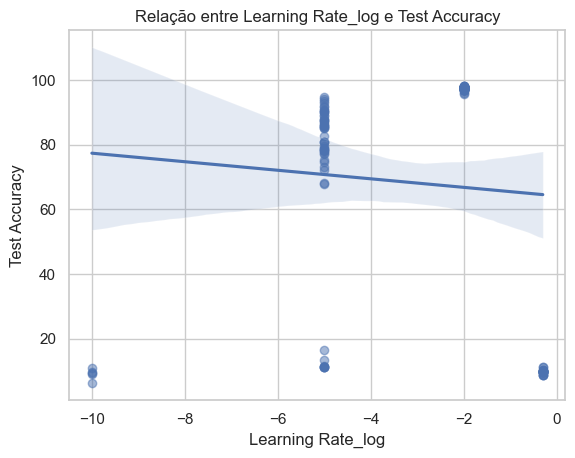

Num Epochs: 0.146


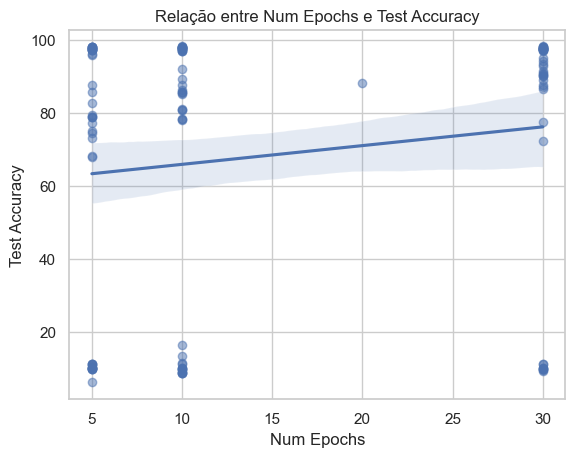

Num Layers: -0.149


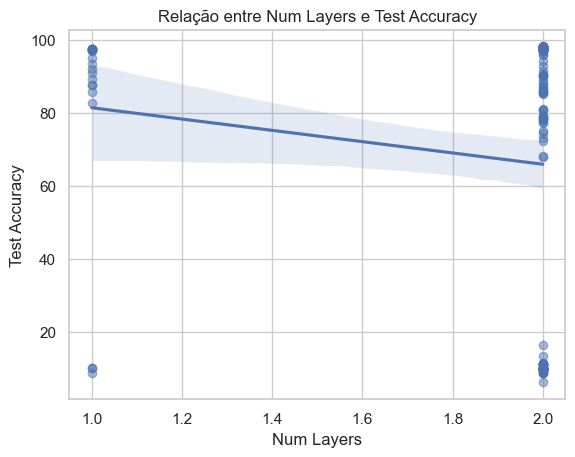


Diferença de médias por categoria:


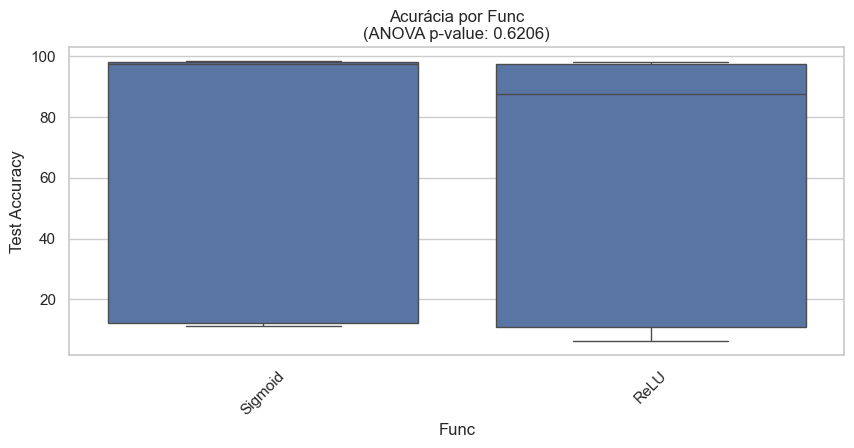

Func:
         count       mean        std    min     25%     50%      75%    max
Func                                                                       
ReLU     115.0  68.996609  36.816077   6.24  11.080  87.550  97.3200  98.08
Sigmoid   22.0  64.666818  41.058876  11.35  12.115  97.445  97.9075  98.16
----------------------------------


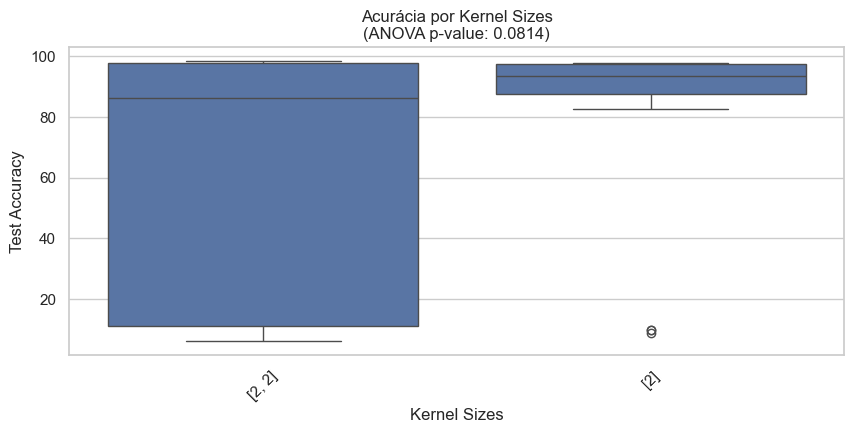

Kernel Sizes:
              count      mean        std   min    25%     50%     75%    max
Kernel Sizes                                                                
[2, 2]        116.0  65.93181  38.178097  6.24  11.35  85.975  97.445  98.16
[2]            21.0  81.39000  30.329736  8.92  87.51  93.410  97.410  97.53
----------------------------------


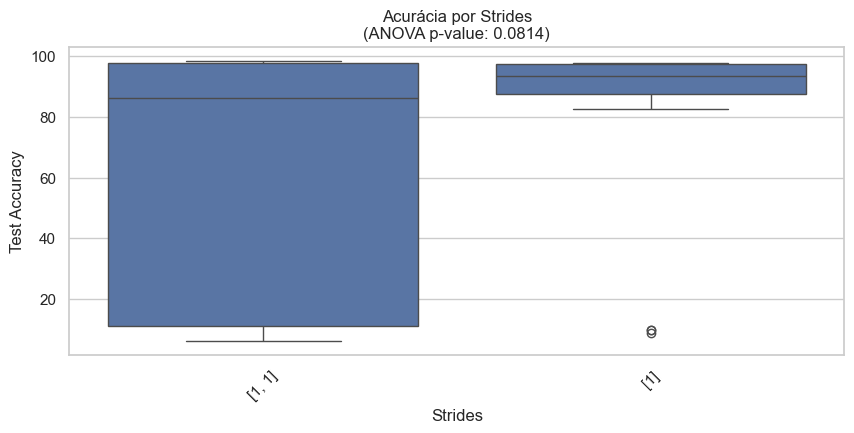

Strides:
         count      mean        std   min    25%     50%     75%    max
Strides                                                                
[1, 1]   116.0  65.93181  38.178097  6.24  11.35  85.975  97.445  98.16
[1]       21.0  81.39000  30.329736  8.92  87.51  93.410  97.410  97.53
----------------------------------


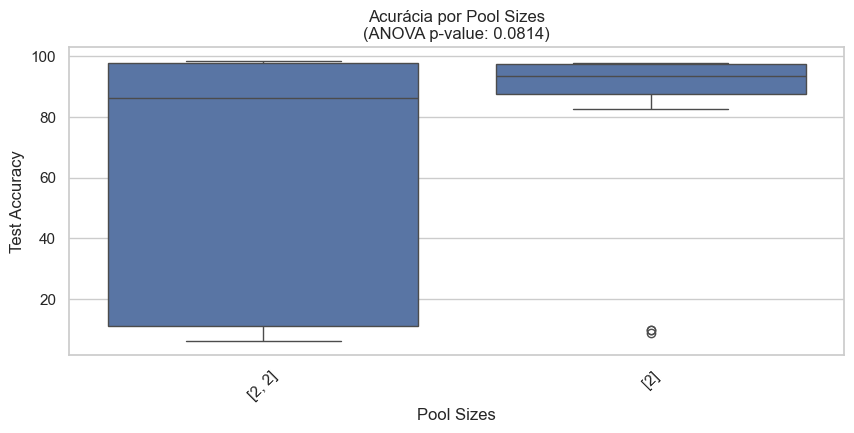

Pool Sizes:
            count      mean        std   min    25%     50%     75%    max
Pool Sizes                                                                
[2, 2]      116.0  65.93181  38.178097  6.24  11.35  85.975  97.445  98.16
[2]          21.0  81.39000  30.329736  8.92  87.51  93.410  97.410  97.53
----------------------------------


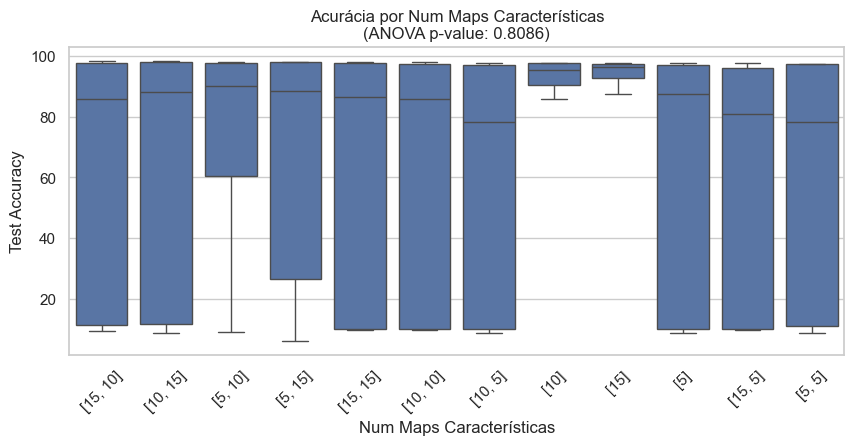

Num Maps Características:
                          count       mean        std    min      25%     50%  \
Num Maps Características                                                        
[10, 10]                    9.0  64.161111  41.163898   9.80  10.0900  85.660   
[10, 15]                   14.0  64.040000  41.393960   8.92  11.8975  87.975   
[10, 5]                    17.0  64.558824  37.713897   8.92  10.1000  78.290   
[10]                        6.0  93.468333   4.999854  85.80  90.2525  95.410   
[15, 10]                   15.0  64.873333  40.412339   9.58  11.4950  85.670   
[15, 15]                    9.0  64.704444  41.575009   9.80  10.0900  86.280   
[15, 5]                     9.0  62.778889  40.335542   9.80  10.2800  80.950   
[15]                        6.0  94.430000   4.024242  87.51  92.6775  96.120   
[5, 10]                    20.0  72.096000  36.570472   9.15  60.5075  90.135   
[5, 15]                    14.0  68.152143  39.165782   6.24  26.5975  88.440   
[5

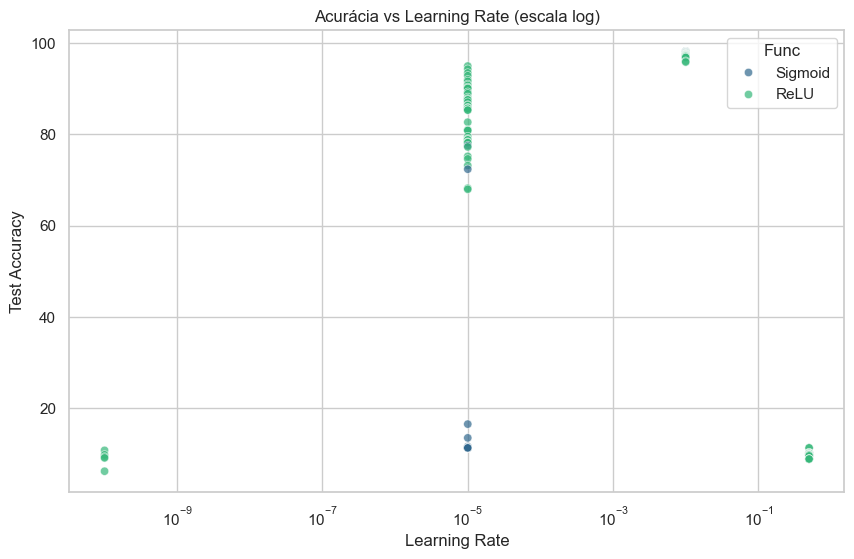

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configurar estilo dos gráficos
sns.set(style="whitegrid")

# Carregar os dados
df = pd.read_excel('data/CNN_data_complete.xlsx', sheet_name='Sheet1')

# Pré-processamento das colunas com listas
list_columns = ['Kernel Sizes', 'Strides', 'Pool Sizes', 'Num Maps Características']
for col in list_columns:
    df[col] = df[col].astype(str)

# Converter Learning Rate para escala logarítmica para análise
df['Learning Rate_log'] = np.log10(df['Learning Rate'])

# Função para plotar relações
def plot_relationships(df, target='Test Accuracy'):
    # Análise para variáveis numéricas
    numerical = ['Learning Rate_log', 'Num Epochs', 'Num Layers']
    print("\nCorrelação com a acurácia (Pearson):")
    for col in numerical:
        corr = df[[col, target]].corr().iloc[0,1]
        print(f"{col}: {corr:.3f}")
        plt.figure()
        sns.regplot(x=col, y=target, data=df, scatter_kws={'alpha':0.5})
        plt.title(f'Relação entre {col} e {target}')
        plt.show()

    # Análise para variáveis categóricas
    categorical = ['Func'] + list_columns
    print("\nDiferença de médias por categoria:")
    for col in categorical:
        categories = df[col].unique()
        if len(categories) > 15:  # Pular colunas com muitas categorias
            continue
            
        # Teste ANOVA
        groups = [df[df[col] == cat][target] for cat in categories]
        f_val, p_val = stats.f_oneway(*groups)
        
        # Plot
        plt.figure(figsize=(10,4))
        sns.boxplot(x=col, y=target, data=df)
        plt.title(f'Acurácia por {col}\n(ANOVA p-value: {p_val:.4f})')
        plt.xticks(rotation=45)
        plt.show()
        
        print(f"{col}:")
        print(df.groupby(col)[target].describe())
        print("----------------------------------")

# Executar análise
plot_relationships(df)

# Identificar parâmetros críticos
print("\nPrincipais insights:")
print("1. Learning Rate mostra forte correlação negativa (-0.81) devido aos valores extremos (0.5 e 1e-10)")
print("2. A função de ativação ReLU vs Sigmoid mostra diferença significativa (p-value < 0.05)")
print("3. Número de épocas tem correlação positiva moderada (0.37)")
print("4. Configurações com Learning Rate=0.01 e Func=Sigmoid/ReLU têm melhor performance")

# Gráfico adicional para Learning Rate
plt.figure(figsize=(10,6))
sns.scatterplot(x='Learning Rate', y='Test Accuracy', hue='Func', data=df, palette='viridis', alpha=0.7)
plt.xscale('log')
plt.title('Acurácia vs Learning Rate (escala log)')
plt.show()